# Campus Placement Prediction with Logistic Regression

Import the libraries that will be used:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Read in and inspect the data.

In [2]:
df = pd.read_csv('Placement_Data_Full_Class.csv')

In [3]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


No missing data besides 'salary' for those who were not placed. 

Rename all features for readability and remove 'sl_no'.

In [5]:
df = df.drop('sl_no',axis=1)

df.rename(inplace=True,columns={'gender':'Gender','ssc_p':'Secondary Ed %','ssc_b':'Secondary Board',
                   'hsc_p':'Higher Secondary Ed %','hsc_b':'Higher Secondary Board',
                   'hsc_s':'Higher Secondary Specialization','degree_p':'Degree %',
                   'degree_t':'Under Grad Field','workex':'Work Exp','etest_p':'Employability Test %',
                   'specialisation':'Post Grad Specialization','mba_p':'MBA %','status':'Placement Status',
                                'salary':'Salary'})

## Exploratory Data Analysis

Explore features in the data and the relationship to 'Placement Status':

### Placement Status

<AxesSubplot:xlabel='Placement Status', ylabel='count'>

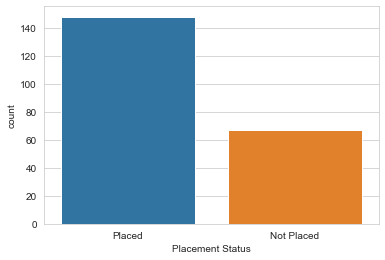

In [6]:
sns.countplot(x='Placement Status',data= df)

In [7]:
(len(df[df['Placement Status'] == 'Placed']) / len(df['Placement Status']))*100

68.83720930232559

About 69% of the data are for those who were placed. 

### Gender

<AxesSubplot:xlabel='Placement Status', ylabel='count'>

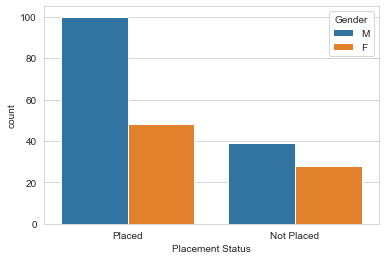

In [8]:
sns.countplot(x='Placement Status',data= df,hue='Gender')

Appears that men are more likely than females to be placed. Let's look closer. First define a function to print Placement Status percentages for each unique value in a feature.

In [9]:
def feature_classification_percent(dataframe, feature, goalfeature, positive_goal_value):
    
    unique_lst = []
    unique_dic = {}
    
    # Add all unique values in feature to a list
    for i in range(len(dataframe[feature].unique())):
        unique_lst.append(dataframe[feature].unique()[i])

    
    # Count the amount for each value in feature and count the amount of each value in that feature that the goalfeature is 1
    # Calculate the percentage of that feature that the goalfeature is 1
    # Add information for each value to a calculated values list
    tot_lst = []
    pos_lst = []
    pos_perc_lst = []
    
    for j in range(len(unique_lst)):
        tot = dataframe[dataframe[feature] == unique_lst[j]][goalfeature].count()
        pos = len(dataframe[(dataframe[feature] == unique_lst[j]) & (dataframe[goalfeature] == positive_goal_value)])
        pos_perc = str(round((pos / tot) * 100,1)) + '%'
        
        tot_lst.append(tot)
        pos_lst.append(pos)
        pos_perc_lst.append(pos_perc)
        
        
    # Convert these lists into Series and create index Series
    tot_series = pd.Series(tot_lst)
    pos_series = pd.Series(pos_lst)
    pos_perc_series = pd.Series(pos_perc_lst)
    value_series = pd.Series(unique_lst)
    
    #Create Dataframe from Series
    feature_dataframe = pd.DataFrame({'Values':value_series,'Total Amount':tot_series,'Positive Amount':pos_series,'Positive Percentage':pos_perc_series})
    feature_dataframe.set_index('Values',inplace=True)
    feature_dataframe.sort_values(by='Positive Percentage',inplace=True, ascending=False)
   
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(feature_dataframe)

In [10]:
feature_classification_percent(df,'Gender','Placement Status','Placed')

,Total Amount,Positive Amount,Positive Percentage
Values,,,
M,139,100,71.9%
F,76,48,63.2%


71.9% of men and 63.2% of women are placed. There are more men that were placed in the data and they were more likely to be placed.

### Secondary Ed %

/Users/colinpierce/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Secondary Ed %', ylabel='Placement Status'>

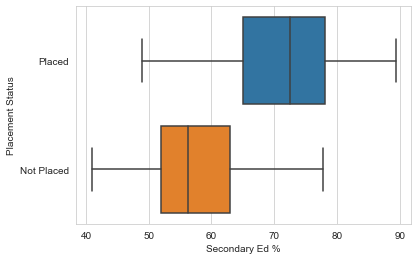

In [11]:
sns.boxplot('Secondary Ed %','Placement Status',data=df)

As 'Secondary Ed %' increases, likeliness of being placed increases.

### Secondary Board

<AxesSubplot:xlabel='Placement Status', ylabel='count'>

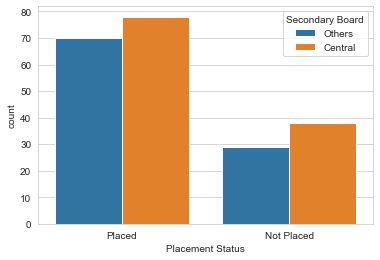

In [12]:
sns.countplot(x='Placement Status',data= df,hue='Secondary Board')

In [13]:
feature_classification_percent(df,'Secondary Board','Placement Status','Placed')

,Total Amount,Positive Amount,Positive Percentage
Values,,,
Others,99,70,70.7%
Central,116,78,67.2%


'Secondary Board' doesn't appear to have much impact on 'Placement Status'

### Higher Secondary Ed %

/Users/colinpierce/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Higher Secondary Ed %', ylabel='Placement Status'>

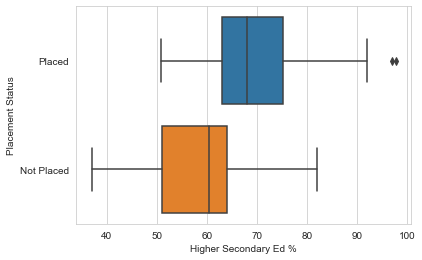

In [14]:
sns.boxplot('Higher Secondary Ed %','Placement Status',data=df)

'Higher Secondary Ed %' appears to increase likeliness of being placed.

### Higher Secondary Board

<AxesSubplot:xlabel='Placement Status', ylabel='count'>

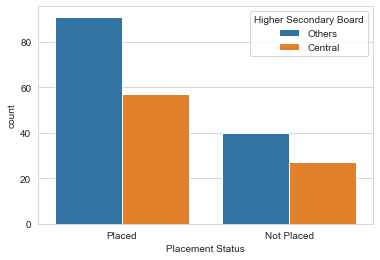

In [15]:
sns.countplot(x='Placement Status',data= df,hue='Higher Secondary Board')

In [16]:
feature_classification_percent(df,'Higher Secondary Board','Placement Status','Placed')

,Total Amount,Positive Amount,Positive Percentage
Values,,,
Others,131,91,69.5%
Central,84,57,67.9%


Again, the 'Higher Secondary Board' doesn't seem to influence 'Placement Status'.

### Higher Secondary Specialization

<AxesSubplot:xlabel='Higher Secondary Specialization', ylabel='count'>

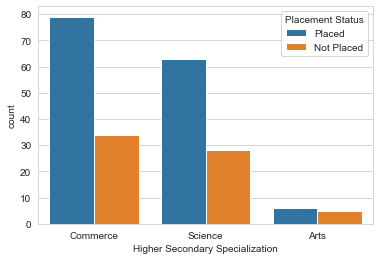

In [17]:
sns.countplot(x='Higher Secondary Specialization',data= df,hue='Placement Status')

In [18]:
feature_classification_percent(df,'Higher Secondary Specialization','Placement Status','Placed')

,Total Amount,Positive Amount,Positive Percentage
Values,,,
Commerce,113,79,69.9%
Science,91,63,69.2%
Arts,11,6,54.5%


Commerce and Science specializations have the same chance of being placed, but Arts is less likely. 

### Degree %

/Users/colinpierce/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Degree %', ylabel='Placement Status'>

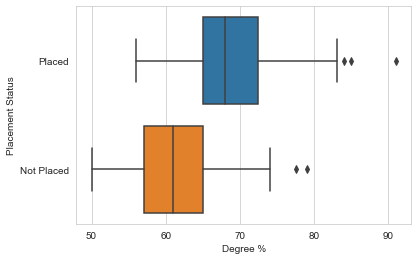

In [19]:
sns.boxplot('Degree %','Placement Status',data=df)

As 'Degree %' increases, likeliness of being placed also increases.

### Under Grad Degrees

<AxesSubplot:xlabel='Placement Status', ylabel='count'>

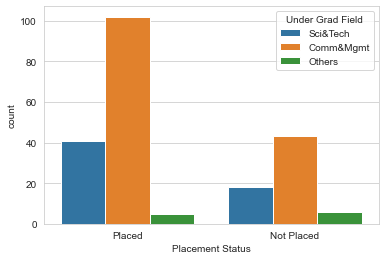

In [20]:
sns.countplot(x='Placement Status',data= df,hue='Under Grad Field')

In [21]:
feature_classification_percent(df,'Under Grad Field','Placement Status','Placed')

,Total Amount,Positive Amount,Positive Percentage
Values,,,
Comm&Mgmt,145,102,70.3%
Sci&Tech,59,41,69.5%
Others,11,5,45.5%


### Work Experience

<AxesSubplot:xlabel='Placement Status', ylabel='count'>

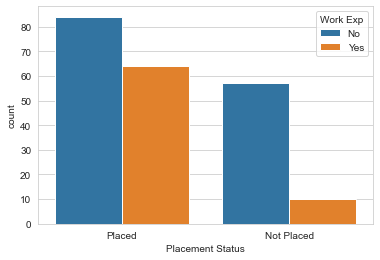

In [22]:
sns.countplot(x='Placement Status',data= df,hue='Work Exp')

'Work Experience' appears to influence 'Placement Status' if they have Work Experience as most were placed. Those without Work Experience are split between both. 

### Employability Test

/Users/colinpierce/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Employability Test %', ylabel='Placement Status'>

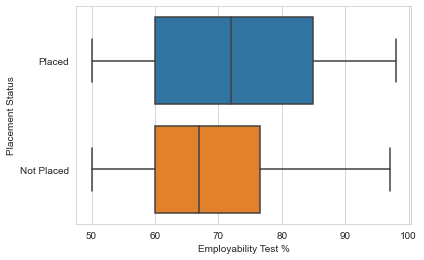

In [23]:
sns.boxplot('Employability Test %','Placement Status',data=df)

A lot of overlap, but it may still may influence 'Placement Status'.

### Post Grad Specialization

<AxesSubplot:xlabel='Placement Status', ylabel='count'>

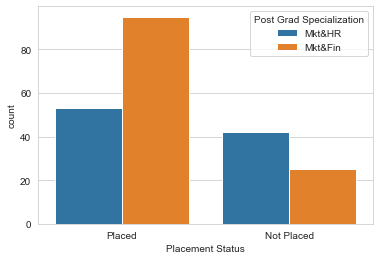

In [24]:
sns.countplot(x='Placement Status',data= df,hue='Post Grad Specialization')

In [25]:
feature_classification_percent(df,'Post Grad Specialization','Placement Status','Placed')

,Total Amount,Positive Amount,Positive Percentage
Values,,,
Mkt&Fin,120,95,79.2%
Mkt&HR,95,53,55.8%


Those with 'Mkt&Fin' were more likely to be placed. This is also true for 'Mkt&HR' but far less so.

### MBA %

/Users/colinpierce/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='MBA %', ylabel='Placement Status'>

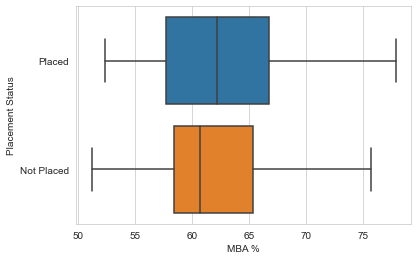

In [26]:
sns.boxplot('MBA %','Placement Status',data=df)

A lot of overlap for this feature as well.

## Data Cleaning

Before making the feature objects into numerical and creating dummies, I will drop both school boards because they don't seem to correlate with placement.

In [27]:
df.drop(['Secondary Board','Higher Secondary Board'],axis=1,inplace=True)

Use map function to assign numerical values to features:

In [28]:
df['Gender'] = df['Gender'].map({'M':0,'F':1})
df['Work Exp'] = df['Work Exp'].map({'No':0,'Yes':1})
df['Placement Status'] = df['Placement Status'].map({'Not Placed':0,'Placed':1})

Get dummies for the other features that have more than 2 unique values:

In [29]:
df = pd.get_dummies(df)

## Outliers

/Users/colinpierce/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Salary'>

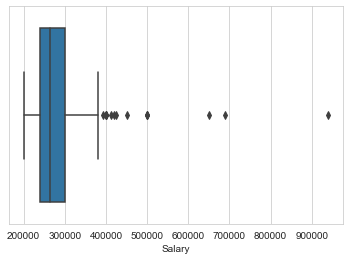

In [30]:
sns.boxplot(df['Salary'])

Remove any data with 'Salary' above 400000.

In [31]:
df = df.drop(df[df['Salary'] > 400000].index)

With these outliers removed, let's drop salary because it can't be used to predict 'Placement Status'.

In [32]:
df.drop('Salary',axis=1,inplace=True)

## Correlation Plots

<AxesSubplot:>

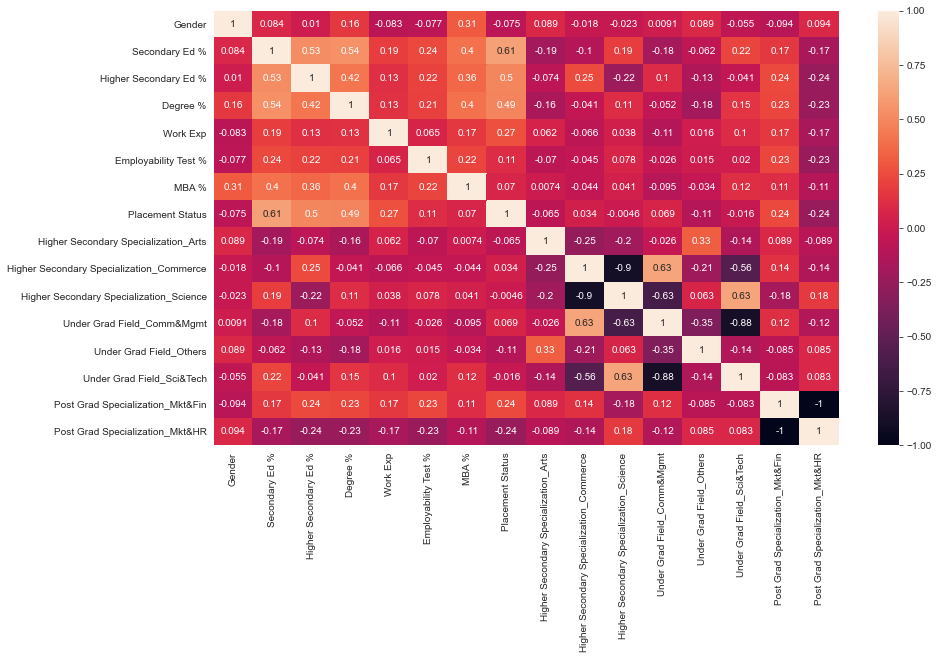

In [33]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(),annot=True)

Remove more features that show signs of multicoliniarity (>0.7)

- Higher Secondary Specialization (remove science)
- Under Grad Field (remove Sci&Tech)
- Post Grad Specialization (remove Mkt&HR)

In [34]:
df = df.drop(['Higher Secondary Specialization_Science','Under Grad Field_Sci&Tech',
                'Post Grad Specialization_Mkt&HR'],axis=1)

<AxesSubplot:>

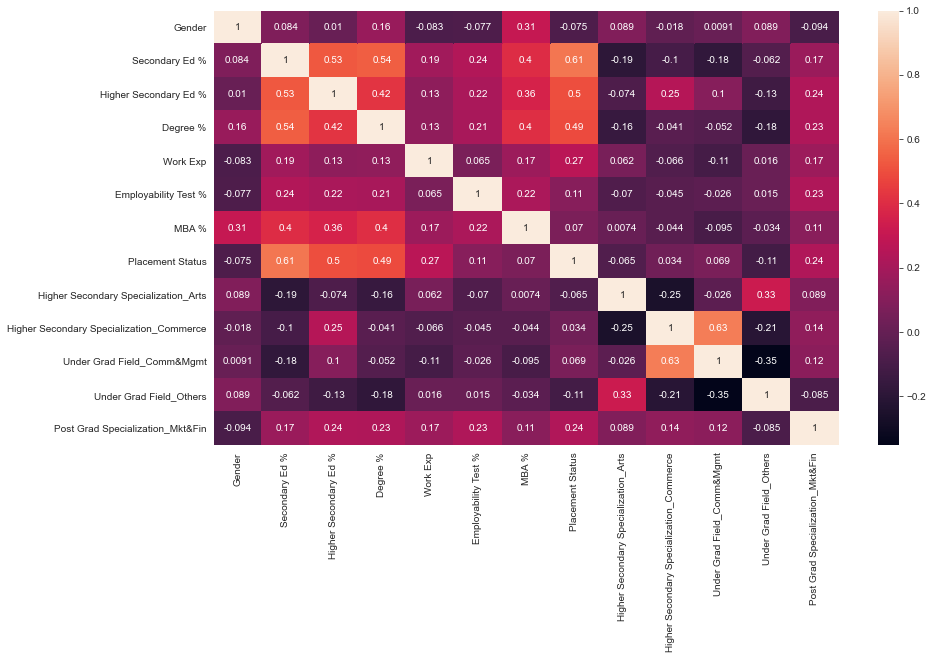

In [35]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(),annot=True)

Drop more features that have low correlation with 'Placement Status':

In [36]:
df = df.drop(['Gender','Under Grad Field_Comm&Mgmt','Under Grad Field_Others','MBA %',
                           'Higher Secondary Specialization_Arts',
                           'Higher Secondary Specialization_Commerce'],axis=1)

<AxesSubplot:>

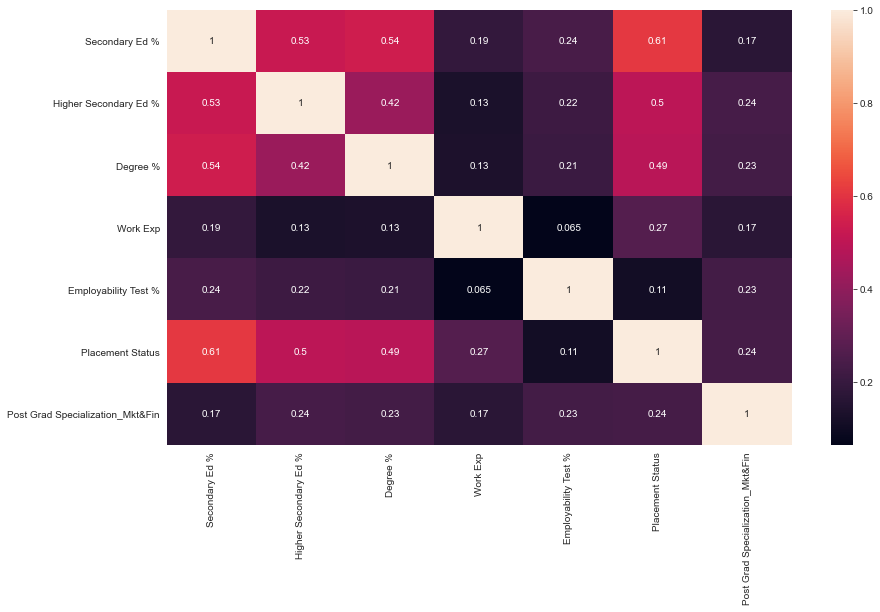

In [37]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(),annot=True)

## Predict Placement Status

In [38]:
X = df.drop('Placement Status',axis=1)
y = df['Placement Status']

### Scale the Data

Use Sklearn's MinMaxScaler to scale the test data.

In [39]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Train/Test Split

Split the data into train and test dataframes. Use 30% of the data as the test set.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

### Logistic Regression Model

Train a logistic regression model to predict 'Placement Status' of the test set. 

In [41]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [42]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.93      0.96      0.95        45

    accuracy                           0.92        62
   macro avg       0.90      0.89      0.90        62
weighted avg       0.92      0.92      0.92        62

[[14  3]
 [ 2 43]]
